# DB2 Data Cleaning

## Introduction

In this project, we aim to predict the performance of database transfers based on various system and transfer-related parameters. We utilize performance benchmark datasets from nine different experiments to train and evaluate several machine learning models. The target variable for our prediction is the `TotaltransferTime`.

The steps involved in this project are as follows:
1. **Data Loading and Concatenation**: Load performance data from nine experiments and concatenate them into a single DataFrame.
2. **Feature Engineering**: Aggregate relevant table statistics and add them to the main DataFrame.
3. **Data Cleaning**: Remove duplicate rows and handle missing values.
4. **Data Visualization**: Visualize data to understand correlations and distributions.
5. **Data Preprocessing**: Create preprocessing pipelines for numerical and categorical data.
6. **Model Selection and Training**: Train multiple machine learning models and evaluate their performance.

## 1. Data Loading and Concatenation

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
import dalex as dx
import matplotlib.pyplot as plt
import yaml
import requests


Declairing all the tables that we use in the experiemtns.

In [2]:
tables = {
    'Table name': ["LINEITEM1", "GIGANTICORDERS", "ORDERS2", "ORDERS3", "ORDERS4", "ORDERS5", "ORDERS6", "ORDERS7", "ORDERS8", "ORDERS10", "ORDERSWIDE2"],
    'Data size(MB)': [674, 5477, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 275, 5337],
    'number of rows': [3894493, 45000000, 15000000, 15000000, 15000000, 15000000, 15000000, 15000000,  15000000, 1993416, 15000000],
    'number of columns': [16, 9, 9, 9, 9, 9, 9, 9, 9, 9, 27]
    }

tables_df = pd.DataFrame(tables)
tables_df.head()

,Table name,Data size(MB),number of rows,number of columns
0,LINEITEM1,674,3894493,16
1,GIGANTICORDERS,5477,45000000,9
2,ORDERS2,1825,15000000,9
3,ORDERS3,1825,15000000,9
4,ORDERS4,1825,15000000,9


The system configuation for the first 24 experiemnts.

In [3]:
source_machine_specs = {
    'RAM (GB)': [120],
    'CPU': [16],
    'Disk (GB)': [20],
    'External Disk (GB)': [576]
    }

source_machine_df = pd.DataFrame(source_machine_specs)
source_machine_df.head()

,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,120,16,20,576


In [4]:
# Function to extract numeric part from RAM string (e.g. "10g" -> 10)
def extract_ram_value(ram_str):
    return float(''.join(filter(str.isdigit, ram_str)))

The system configuration for the 9 experiemtns in version 2 experiments.

In [5]:
# List of URLs containing YAML files
urls = [
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp1/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp2/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp3/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp4/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp5/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp6/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp7/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp8/docker-compose.yml",
    "https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp9/docker-compose.yml"
]

# List to store the parsed CPU and memory information from each YAML
parsed_yaml_data = []

# Loop through each URL and fetch YAML content
for url in urls:
    try:
        # Fetch the content of the YAML file
        response = requests.get(url)
        
        # Check if the request was successful
        if response.status_code == 200:
            # Parse YAML content
            yaml_content = yaml.safe_load(response.text)
            
            # Check if 'deploy' and resource limits are present, otherwise use source_machine_df values
            if 'deploy' in yaml_content['services']['web'] and 'resources' in yaml_content['services']['web']['deploy']:
                # Extract 'cpus' and 'memory' (ram) limits from YAML or use machine's full capacity
                cpus = yaml_content['services']['web']['deploy']['resources']['limits'].get('cpus', source_machine_df["CPU"].values[0])
                cpus = float(cpus) * source_machine_df["CPU"].values[0]

                ram = yaml_content['services']['web']['deploy']['resources']['limits'].get('memory', f'{source_machine_df["RAM (GB)"].values[0]}g')
                ram_value = extract_ram_value(ram)  # Extract only the numeric part
            else:
                # If 'deploy' or resource limits are missing, use the entire source_machine_df values
                cpus = source_machine_df["CPU"].values[0]  # Access the first value
                ram_value = source_machine_df["RAM (GB)"].values[0]  # Access the first value
            
            # Append the extracted information as a dictionary to the list
            parsed_yaml_data.append({'CPU': cpus, 'RAM (GB)': ram_value})
            print(f"Successfully fetched and parsed: {url}")
        else:
            print(f"Failed to fetch {url}. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error while fetching {url}: {e}")

yaml_df = pd.DataFrame(parsed_yaml_data)

# Optionally, inspect the new DataFrame
# print("New DataFrame created from YAML content:")
# print(yaml_df)

Successfully fetched and parsed: https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp1/docker-compose.yml
Successfully fetched and parsed: https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp2/docker-compose.yml
Successfully fetched and parsed: https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp3/docker-compose.yml
Successfully fetched and parsed: https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp4/docker-compose.yml
Successfully fetched and parsed: https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp5/docker-compose.yml
Successfully fetched and parsed: https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp6/docker-compose.yml
Successfully fetched and parsed: https:/

In [6]:
# print(yaml['services']['web']['deploy']['resources']['limits']['cpus'])
yaml_df


,CPU,RAM (GB)
0,1.6,10.0
1,0.8,10.0
2,0.8,10.0
3,16.0,120.0
4,0.8,10.0
5,1.6,10.0
6,1.6,10.0
7,0.8,10.0
8,0.8,10.0


Importing the experiments.

In [7]:
# Load the performance benchmark datasets
exp1_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp1/performanceBenchmark.csv')
exp2_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp2/performanceBenchmark.csv')
exp3_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp3/performanceBenchmark.csv')
exp4_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp4/performanceBenchmark.csv')
exp5_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp5/performanceBenchmark.csv')
exp6_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp6/performanceBenchmark.csv')
exp7_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp7/performanceBenchmark.csv')
exp8_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp8/performanceBenchmark.csv')
exp9_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp9/performanceBenchmark.csv')
exp10_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp10/performanceBenchmark.csv')
exp11_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp11/performanceBenchmark.csv')
exp12_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp12/performanceBenchmark.csv')
exp13_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp13/performanceBenchmark.csv')
exp14_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp14/performanceBenchmark.csv')
exp15_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp15/performanceBenchmark.csv')
exp16_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp16/performanceBenchmark.csv')
exp17_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp17/performanceBenchmark.csv')
exp18_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp18/performanceBenchmark.csv')
exp19_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp19/performanceBenchmark.csv')
exp20_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp20/performanceBenchmark.csv')
exp21_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp21/performanceBenchmark.csv')
exp22_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp22/performanceBenchmark.csv')
exp23_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp23/performanceBenchmark.csv')
exp24_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp24/performanceBenchmark.csv')
v2_exp1_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp1/performanceBenchmark.csv')
v2_exp2_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp2/performanceBenchmark.csv')
v2_exp3_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp3/performanceBenchmark.csv')
v2_exp4_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp4/performanceBenchmark.csv')
v2_exp5_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp5/performanceBenchmark.csv')
v2_exp6_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp6/performanceBenchmark.csv')
v2_exp7_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp7/performanceBenchmark.csv')
v2_exp8_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp8/performanceBenchmark.csv')
v2_exp9_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/refs/heads/main/Data/DB2%20Performance%20Datasets/v2/exp9/performanceBenchmark.csv')

In [8]:
exp1_performance_df.head()

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime
0,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3296.018193,3266.620216,32.906244,NaN
1,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,622.369466,588.320576,3.208371,NaN
2,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1945.972293,1920.935266,3.742569,NaN
3,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3834.102760,3783.924402,6.611556,NaN
4,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1933.460342,1901.642637,6.197286,NaN


In [9]:
print(exp10_performance_df.columns)

Index(['Experiment Number', 'compress', 'sourceDatabasetoTargetDatabase',
       'tables', 'maxStreams', 'binary', 'Experiment startTime',
       'TotalExperimentTime', 'TotaltransferTime', 'totalPrecheckTime',
       'TotalClearTime'],
      dtype='object')


In [10]:
v2_exp8_performance_df.drop(v2_exp8_performance_df.tail(1).index, inplace=True)
v2_exp8_performance_df.tail(10)

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime
4,5,NO,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726169e+09,5308.884032,4550.101039,247.407962,6.561349
5,1,GZIP,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726203e+09,4449.286099,3703.900795,289.613249,4.588818
6,2,GZIP,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726203e+09,5666.211861,4878.199970,245.691966,41.705382
7,3,GZIP,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726203e+09,4073.898144,3315.093996,284.016738,5.839195
8,4,GZIP,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726203e+09,5038.388140,4293.599903,227.205449,3.987905
9,5,GZIP,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726203e+09,3970.035422,3166.298856,246.810068,46.200249
10,1,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,3959.046351,3031.400081,184.198949,191.827737
11,2,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,4251.160840,3268.497884,239.703630,236.805045
12,3,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,5961.989170,5473.799116,228.695376,334.928746
13,4,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,5150.957639,4401.501568,232.703128,4.992518


## TO DO:  MAKE THE DATA AND ADDING THE SPECS TO THEM EFFICIENT!!

In [11]:
# Assuming `v2_performance_dfs` contains the list of dataframes and `yaml_df` contains the extracted CPU/RAM values
v2_performance_dfs = [v2_exp1_performance_df, v2_exp2_performance_df, v2_exp3_performance_df,
                      v2_exp4_performance_df, v2_exp5_performance_df, v2_exp6_performance_df,
                      v2_exp7_performance_df, v2_exp8_performance_df, v2_exp9_performance_df]

# Extract the Disk and External Disk values from `source_machine_df`
disk_value = source_machine_df['Disk (GB)'].values[0]
external_disk_value = source_machine_df['External Disk (GB)'].values[0]

# Loop over each DataFrame and the corresponding row from yaml_df
extended_dfs = []  # To store the extended DataFrames

for i, df in enumerate(v2_performance_dfs):
    # Get the corresponding row from yaml_df (i-th row)
    yaml_row = yaml_df.iloc[i]
    
    # Repeat the values of yaml_row for the number of rows in the respective performance DataFrame
    repeated_yaml_row = pd.DataFrame([yaml_row] * len(df), index=df.index)
    
    # Add the Disk and External Disk values to every row of the DataFrame
    repeated_yaml_row['Disk (GB)'] = disk_value
    repeated_yaml_row['External Disk (GB)'] = external_disk_value
    
    # Concatenate the repeated yaml_row with the current performance DataFrame
    extended_df = pd.concat([df, repeated_yaml_row], axis=1)
    
    # Add the extended DataFrame to the list
    extended_dfs.append(extended_df)

# Combine all the extended DataFrames into one
v2_performance_df = pd.concat(extended_dfs, ignore_index=True)


In [12]:
v2_performance_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,CPU,RAM (GB),Disk (GB),External Disk (GB)
0,1,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,2078.446037,1316.606168,254.308353,2.999866,1.6,10.0,20,576
1,2,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1804.069990,1047.599877,307.916508,5.783820,1.6,10.0,20,576
2,3,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1799.690132,0.000000,0.000000,56.280673,1.6,10.0,20,576
3,4,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1386.654521,1168.301981,276.305505,46.940669,1.6,10.0,20,576
4,5,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,927.905531,0.000000,246.076808,68.022536,1.6,10.0,20,576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,1,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,3959.046351,3031.400081,184.198949,191.827737,0.8,10.0,20,576
195,2,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,4251.160840,3268.497884,239.703630,236.805045,0.8,10.0,20,576
196,3,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,5961.989170,5473.799116,228.695376,334.928746,0.8,10.0,20,576
197,4,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,5150.957639,4401.501568,232.703128,4.992518,0.8,10.0,20,576


Concatenating all the experiments

In [13]:
performance_dfs = [exp1_performance_df, exp2_performance_df, exp3_performance_df, 
                   exp4_performance_df, exp5_performance_df, exp6_performance_df, 
                   exp7_performance_df, exp8_performance_df, exp9_performance_df,
                   exp10_performance_df, exp11_performance_df, exp12_performance_df,
                   exp13_performance_df, exp14_performance_df, exp15_performance_df,
                   exp16_performance_df, exp17_performance_df, exp18_performance_df,
                   exp19_performance_df, exp20_performance_df, exp21_performance_df,
                   exp22_performance_df, exp23_performance_df, exp24_performance_df]

performance_df = pd.concat(performance_dfs, ignore_index=True)


In [14]:
performance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Experiment Number               372 non-null    int64  
 1   compress                        372 non-null    object 
 2   sourceDatabasetoTargetDatabase  372 non-null    object 
 3   tables                          372 non-null    object 
 4   maxStreams                      372 non-null    int64  
 5   binary                          372 non-null    bool   
 6   Experiment startTime            372 non-null    float64
 7   TotalExperimentTime             372 non-null    float64
 8   TotaltransferTime               372 non-null    float64
 9   totalPrecheckTime               372 non-null    float64
 10  TotalClearTime                  329 non-null    float64
dtypes: bool(1), float64(5), int64(2), object(3)
memory usage: 29.6+ KB


The `calculate_table_sums` function calculates and aggregates the total data size, number of rows, and number of columns for specified table names within a dataframe. It adds these aggregated values as new features to the original dataframe.

In [15]:
performance_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime
0,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3296.018193,3266.620216,32.906244,NaN
1,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,622.369466,588.320576,3.208371,NaN
2,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1945.972293,1920.935266,3.742569,NaN
3,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3834.102760,3783.924402,6.611556,NaN
4,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1933.460342,1901.642637,6.197286,NaN
...,...,...,...,...,...,...,...,...,...,...,...
367,3,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,587.753326,563.725937,53.784407,2.670337
368,4,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,927.081444,907.880295,36.027611,2.575287
369,5,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,690.811253,550.628901,35.914018,119.534970
370,6,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,542.664062,523.224117,35.282297,2.688195


## 2. Feature Engineering
We define a function `calculate_table_sums` to calculate and aggregate the total data size, number of rows, and number of columns for specified table names within the DataFrame.


In [16]:
def calculate_table_sums(exp_df, tables_df):

    # Extract table names
    table_names_series = exp_df['tables'].str.split('_', expand=False)
    
    # Initialize lists to store the sums
    data_size_sum = []
    rows_sum = []
    columns_sum = []
    print(data_size_sum, rows_sum, columns_sum)

    # Iterate over each row of table names
    for table_names in table_names_series:
        # Filter the info dataframe for the current table names
        filtered_info = tables_df[tables_df['Table name'].isin(table_names)]
        # print(filtered_info)
        # Calculate the sums
        data_size_sum.append(filtered_info['Data size(MB)'].sum())
        rows_sum.append(filtered_info['number of rows'].sum())
        columns_sum.append(filtered_info['number of columns'].sum())
        # print(data_size_sum, rows_sum, columns_sum)


    # Add the sums as new features in the initial dataframe
    exp_df['Data size sum (MB)'] = data_size_sum
    exp_df['Number of rows sum'] = rows_sum
    exp_df['Number of columns sum'] = columns_sum

    
    exp_df = exp_df[['Experiment Number', 'compress', 'sourceDatabasetoTargetDatabase', 'tables', 'Data size sum (MB)', 
                     'Number of rows sum', 'Number of columns sum', 'maxStreams', 'binary', 'Experiment startTime', 
                     'TotalExperimentTime', 'TotaltransferTime', 'totalPrecheckTime', 'TotalClearTime', 'RAM (GB)',	'CPU', 'Disk (GB)', 'External Disk (GB)']]

    return exp_df

In [17]:
performance_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime
0,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3296.018193,3266.620216,32.906244,NaN
1,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,622.369466,588.320576,3.208371,NaN
2,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1945.972293,1920.935266,3.742569,NaN
3,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3834.102760,3783.924402,6.611556,NaN
4,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1933.460342,1901.642637,6.197286,NaN
...,...,...,...,...,...,...,...,...,...,...,...
367,3,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,587.753326,563.725937,53.784407,2.670337
368,4,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,927.081444,907.880295,36.027611,2.575287
369,5,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,690.811253,550.628901,35.914018,119.534970
370,6,NO,testdb_testdb,ORDERSWIDE2,5,False,1.719368e+09,542.664062,523.224117,35.282297,2.688195


In [18]:
v2_performance_df

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,CPU,RAM (GB),Disk (GB),External Disk (GB)
0,1,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,2078.446037,1316.606168,254.308353,2.999866,1.6,10.0,20,576
1,2,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1804.069990,1047.599877,307.916508,5.783820,1.6,10.0,20,576
2,3,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1799.690132,0.000000,0.000000,56.280673,1.6,10.0,20,576
3,4,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1386.654521,1168.301981,276.305505,46.940669,1.6,10.0,20,576
4,5,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,927.905531,0.000000,246.076808,68.022536,1.6,10.0,20,576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,1,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,3959.046351,3031.400081,184.198949,191.827737,0.8,10.0,20,576
195,2,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,4251.160840,3268.497884,239.703630,236.805045,0.8,10.0,20,576
196,3,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,5961.989170,5473.799116,228.695376,334.928746,0.8,10.0,20,576
197,4,LZ4,testdb_testdb,ORDERS2_ORDERS3_ORDERS4_ORDERS5_ORDERS6_ORDERS...,5,False,1.726247e+09,5150.957639,4401.501568,232.703128,4.992518,0.8,10.0,20,576


In [19]:
# Concatenate the experiment tables with the system specs
df2_repeated = pd.concat([source_machine_df]*len(performance_df), ignore_index=True)


result_df = pd.concat([performance_df, df2_repeated], axis=1)

In [20]:
# Ensure that both DataFrames have the same column order
v2_performance_df = v2_performance_df[result_df.columns]

# Concatenate the two DataFrames
result_df = pd.concat([v2_performance_df, result_df], ignore_index=True)



In [21]:
result_df.head(20)

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,1,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,2078.446037,1316.606168,254.308353,2.999866,10.0,1.6,20,576
1,2,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1804.069990,1047.599877,307.916508,5.783820,10.0,1.6,20,576
2,3,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1799.690132,0.000000,0.000000,56.280673,10.0,1.6,20,576
3,4,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1386.654521,1168.301981,276.305505,46.940669,10.0,1.6,20,576
4,5,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,927.905531,0.000000,246.076808,68.022536,10.0,1.6,20,576
5,6,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,2442.184753,1680.701212,297.409373,2.359228,10.0,1.6,20,576
6,7,GZIP,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,5,True,1.725076e+09,1301.701983,1097.199158,330.917276,34.045334,10.0,1.6,20,576
7,1,GZIP,testdb_testdb,GIGANTICORDERS,5,True,1.725087e+09,2906.590192,2689.705929,328.312150,59.996442,10.0,1.6,20,576
8,2,GZIP,testdb_testdb,GIGANTICORDERS,5,True,1.725087e+09,2820.139517,2432.704535,302.293489,235.848617,10.0,1.6,20,576
9,3,GZIP,testdb_testdb,GIGANTICORDERS,5,True,1.725087e+09,3909.006256,3014.900997,282.703190,131.074699,10.0,1.6,20,576


In [23]:
result_df = calculate_table_sums(result_df, tables_df)

[] [] []


In [24]:
result_df.drop(labels=['Experiment Number', 'sourceDatabasetoTargetDatabase', 'tables', 
                            'TotalExperimentTime', 'totalPrecheckTime', 'TotalClearTime', 
                            'Experiment startTime'], axis=1, inplace=True)

In [25]:
result_df

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,GZIP,2774,20887909,34,5,True,1316.606168,10.0,1.6,20,576
1,GZIP,2774,20887909,34,5,True,1047.599877,10.0,1.6,20,576
2,GZIP,2774,20887909,34,5,True,0.000000,10.0,1.6,20,576
3,GZIP,2774,20887909,34,5,True,1168.301981,10.0,1.6,20,576
4,GZIP,2774,20887909,34,5,True,0.000000,10.0,1.6,20,576
...,...,...,...,...,...,...,...,...,...,...,...
566,NO,5337,15000000,27,5,False,563.725937,120.0,16.0,20,576
567,NO,5337,15000000,27,5,False,907.880295,120.0,16.0,20,576
568,NO,5337,15000000,27,5,False,550.628901,120.0,16.0,20,576
569,NO,5337,15000000,27,5,False,523.224117,120.0,16.0,20,576


## 3. Data Cleaning

### 3.1 Check for duplicate rows and remove them if any.


In [26]:
result_df.duplicated().sum()

45

In [27]:
result_df.drop_duplicates()

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,GZIP,2774,20887909,34,5,True,1316.606168,10.0,1.6,20,576
1,GZIP,2774,20887909,34,5,True,1047.599877,10.0,1.6,20,576
2,GZIP,2774,20887909,34,5,True,0.000000,10.0,1.6,20,576
3,GZIP,2774,20887909,34,5,True,1168.301981,10.0,1.6,20,576
5,GZIP,2774,20887909,34,5,True,1680.701212,10.0,1.6,20,576
...,...,...,...,...,...,...,...,...,...,...,...
566,NO,5337,15000000,27,5,False,563.725937,120.0,16.0,20,576
567,NO,5337,15000000,27,5,False,907.880295,120.0,16.0,20,576
568,NO,5337,15000000,27,5,False,550.628901,120.0,16.0,20,576
569,NO,5337,15000000,27,5,False,523.224117,120.0,16.0,20,576


### 3.2 Handle the missing values


In [28]:
result_df.isna().sum()

compress                 0
Data size sum (MB)       0
Number of rows sum       0
Number of columns sum    0
maxStreams               0
binary                   0
TotaltransferTime        0
RAM (GB)                 0
CPU                      0
Disk (GB)                0
External Disk (GB)       0
dtype: int64

In [29]:
result_df

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,GZIP,2774,20887909,34,5,True,1316.606168,10.0,1.6,20,576
1,GZIP,2774,20887909,34,5,True,1047.599877,10.0,1.6,20,576
2,GZIP,2774,20887909,34,5,True,0.000000,10.0,1.6,20,576
3,GZIP,2774,20887909,34,5,True,1168.301981,10.0,1.6,20,576
4,GZIP,2774,20887909,34,5,True,0.000000,10.0,1.6,20,576
...,...,...,...,...,...,...,...,...,...,...,...
566,NO,5337,15000000,27,5,False,563.725937,120.0,16.0,20,576
567,NO,5337,15000000,27,5,False,907.880295,120.0,16.0,20,576
568,NO,5337,15000000,27,5,False,550.628901,120.0,16.0,20,576
569,NO,5337,15000000,27,5,False,523.224117,120.0,16.0,20,576


In [30]:
result_df = result_df.drop(result_df[result_df['TotaltransferTime'] == 0].index)


In [31]:
result_df

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,GZIP,2774,20887909,34,5,True,1316.606168,10.0,1.6,20,576
1,GZIP,2774,20887909,34,5,True,1047.599877,10.0,1.6,20,576
3,GZIP,2774,20887909,34,5,True,1168.301981,10.0,1.6,20,576
5,GZIP,2774,20887909,34,5,True,1680.701212,10.0,1.6,20,576
6,GZIP,2774,20887909,34,5,True,1097.199158,10.0,1.6,20,576
...,...,...,...,...,...,...,...,...,...,...,...
566,NO,5337,15000000,27,5,False,563.725937,120.0,16.0,20,576
567,NO,5337,15000000,27,5,False,907.880295,120.0,16.0,20,576
568,NO,5337,15000000,27,5,False,550.628901,120.0,16.0,20,576
569,NO,5337,15000000,27,5,False,523.224117,120.0,16.0,20,576


In [32]:
# print(result_df['TotaltransferTime'].tolist())

In [33]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 490 entries, 0 to 570
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   compress               490 non-null    object 
 1   Data size sum (MB)     490 non-null    int64  
 2   Number of rows sum     490 non-null    int64  
 3   Number of columns sum  490 non-null    int64  
 4   maxStreams             490 non-null    int64  
 5   binary                 490 non-null    bool   
 6   TotaltransferTime      490 non-null    float64
 7   RAM (GB)               490 non-null    float64
 8   CPU                    490 non-null    float64
 9   Disk (GB)              490 non-null    int64  
 10  External Disk (GB)     490 non-null    int64  
dtypes: bool(1), float64(3), int64(6), object(1)
memory usage: 42.6+ KB


## 4. Visualizing the Data

### 4.1 Correlation Matrix using Pearson correlation coefficient


In [34]:
result_df.describe()

,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
count,490.000000,4.900000e+02,490.000000,490.000000,490.000000,490.000000,490.000000,490.0,490.0
mean,6392.900000,4.265260e+07,30.320408,6.461224,2750.245812,88.571429,11.764898,20.0,576.0
std,4087.018081,3.478621e+07,19.895673,2.798540,3029.128751,49.743719,6.706533,0.0,0.0
min,2774.000000,1.500000e+07,9.000000,1.000000,83.768511,10.000000,0.800000,20.0,576.0
25%,5337.000000,1.500000e+07,9.000000,5.000000,911.217058,10.000000,1.600000,20.0,576.0
50%,5337.000000,2.088791e+07,27.000000,5.000000,1935.787628,120.000000,16.000000,20.0,576.0
75%,5477.000000,4.500000e+07,34.000000,10.000000,3532.334208,120.000000,16.000000,20.0,576.0
max,23589.000000,1.650000e+08,99.000000,10.000000,19425.012430,120.000000,16.000000,20.0,576.0


In [35]:
# Calculate the correlation matrix
corr_matrix = result_df.corr(numeric_only=True)
corr_matrix

,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
Data size sum (MB),1.000000,0.925507,0.736973,0.120406,-0.282925,0.680754,-0.015641,-0.015845,NaN,NaN
Number of rows sum,0.925507,1.000000,0.674038,0.126343,-0.316240,0.692069,-0.019724,-0.019520,NaN,NaN
Number of columns sum,0.736973,0.674038,1.000000,0.096066,-0.303031,0.527315,-0.021625,-0.020388,NaN,NaN
maxStreams,0.120406,0.126343,0.096066,1.000000,-0.269880,0.129346,0.330567,0.330399,NaN,NaN
binary,-0.282925,-0.316240,-0.303031,-0.269880,1.000000,-0.270297,-0.447315,-0.451598,NaN,NaN
TotaltransferTime,0.680754,0.692069,0.527315,0.129346,-0.270297,1.000000,0.161967,0.162480,NaN,NaN
RAM (GB),-0.015641,-0.019724,-0.021625,0.330567,-0.447315,0.161967,1.000000,0.999492,NaN,NaN
CPU,-0.015845,-0.019520,-0.020388,0.330399,-0.451598,0.162480,0.999492,1.000000,NaN,NaN
Disk (GB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
External Disk (GB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4.2 Correlation with regard to the target "Total Transfer Time"


In [36]:
corr_matrix["TotaltransferTime"].sort_values(ascending=False)

TotaltransferTime        1.000000
Number of rows sum       0.692069
Data size sum (MB)       0.680754
Number of columns sum    0.527315
CPU                      0.162480
RAM (GB)                 0.161967
maxStreams               0.129346
binary                  -0.270297
Disk (GB)                     NaN
External Disk (GB)            NaN
Name: TotaltransferTime, dtype: float64

### 4.3 Histogram


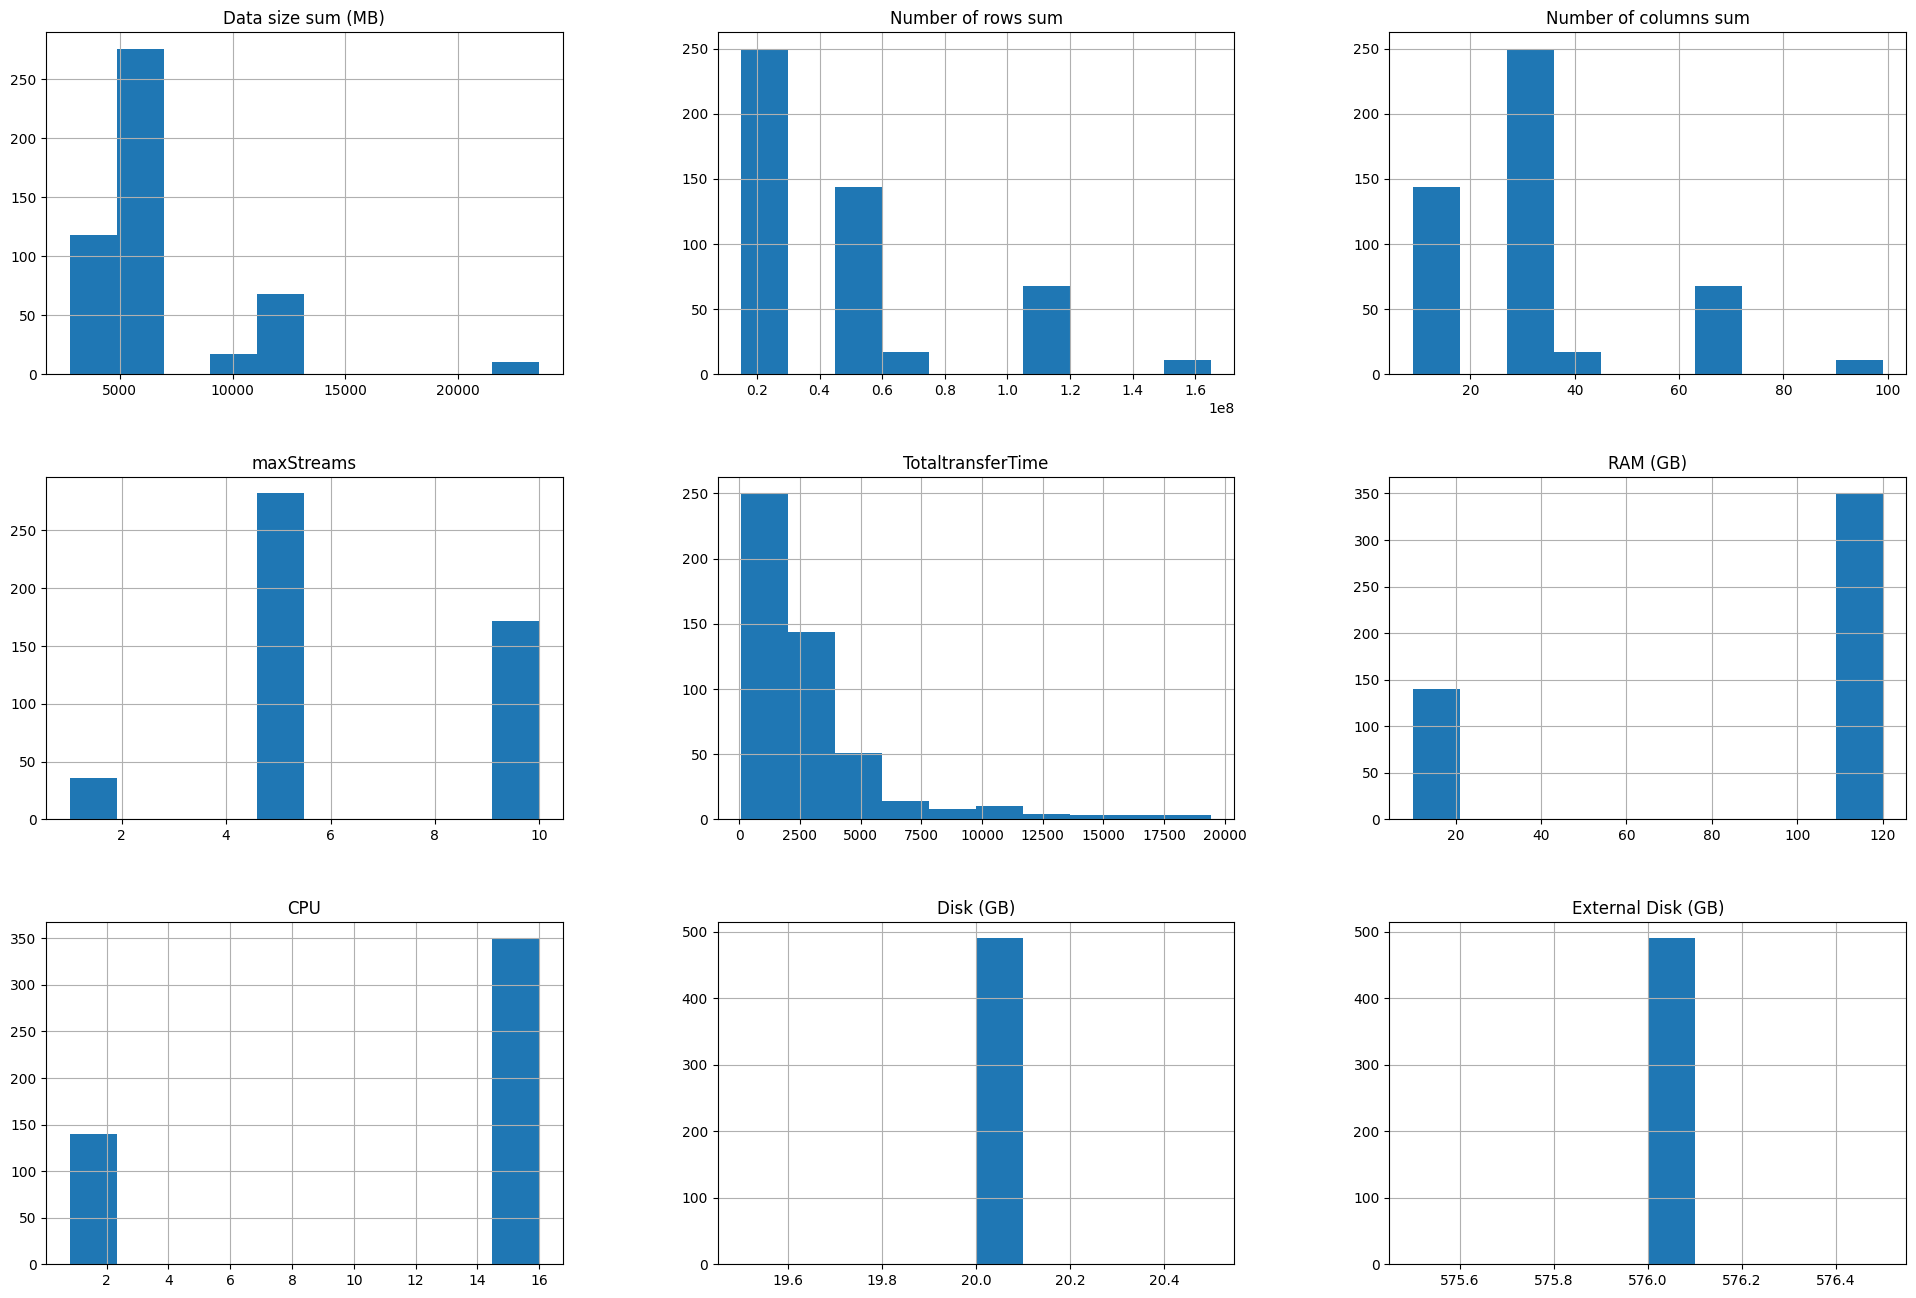

In [37]:
result_df.hist(figsize=(24, 16))
plt.show()

### 4.4 Pairwise correlation using seaborn


In [38]:
# Uncomment to generate pairplot (disabled for performance reasons)

# sns.pairplot(result_df)

## 5. Preprocessing

### 5.1 Create a pipeline


In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [40]:
# Separate numerical and categorical columns
num_cols = result_df.select_dtypes(include='number').columns.to_list()
cat_cols = result_df.select_dtypes(exclude='number').columns.to_list()

# Exclude the target from numerical columns
num_cols.remove("TotaltransferTime")

# Create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

# Use ColumnTransformer to set the estimators and transformations
preprocessing = ColumnTransformer([('num', num_pipeline, num_cols),
                                   ('cat', cat_pipeline, cat_cols)],
                                    remainder='passthrough'
                                 )

In [41]:
# Display the pipeline
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Data size sum (MB)', 'Number of rows sum',
                                  'Number of columns sum', 'maxStreams',
                                  'RAM (GB)', 'CPU', 'Disk (GB)',
                                  'External Disk (GB)']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['compress', 'binary'])])

In [42]:
# Apply the preprocessing pipeline on the dataset
result_df_prepared = preprocessing.fit_transform(result_df)

# Scikit-learn strips the column headers, so just add them back on afterward.
feature_names = preprocessing.get_feature_names_out()
result_df_prepared = pd.DataFrame(data=result_df_prepared, columns=feature_names)

result_df_prepared

,num__Data size sum (MB),num__Number of rows sum,num__Number of columns sum,num__maxStreams,num__RAM (GB),num__CPU,num__Disk (GB),num__External Disk (GB),cat__compress_GZIP,cat__compress_LZ4,cat__compress_NO,cat__binary_False,cat__binary_True,remainder__TotaltransferTime
0,-0.886367,-0.626309,0.185133,-0.522672,-1.581139,-1.517220,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1316.606168
1,-0.886367,-0.626309,0.185133,-0.522672,-1.581139,-1.517220,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1047.599877
2,-0.886367,-0.626309,0.185133,-0.522672,-1.581139,-1.517220,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1168.301981
3,-0.886367,-0.626309,0.185133,-0.522672,-1.581139,-1.517220,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1680.701212
4,-0.886367,-0.626309,0.185133,-0.522672,-1.581139,-1.517220,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1097.199158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,-0.258619,-0.795742,-0.167062,-0.522672,0.632456,0.632134,0.0,0.0,0.0,0.0,1.0,1.0,0.0,563.725937
486,-0.258619,-0.795742,-0.167062,-0.522672,0.632456,0.632134,0.0,0.0,0.0,0.0,1.0,1.0,0.0,907.880295
487,-0.258619,-0.795742,-0.167062,-0.522672,0.632456,0.632134,0.0,0.0,0.0,0.0,1.0,1.0,0.0,550.628901
488,-0.258619,-0.795742,-0.167062,-0.522672,0.632456,0.632134,0.0,0.0,0.0,0.0,1.0,1.0,0.0,523.224117


## 6. Selecting Model and Training

### 6.1 Split the dataset into a training dataset (80%) and testing dataset (20%).


In [43]:
from sklearn.model_selection import train_test_split

# Splitting data into features and target variable
X = result_df_prepared.drop(["remainder__TotaltransferTime"], axis=1)
y = result_df_prepared["remainder__TotaltransferTime"]

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(392, 13) (392,) (98, 13) (98,)


### 6.2 Define a function to report regression metrics


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_report(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    report = {
        "Mean Absolute Error (MAE)": mae,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "R² Score": r2
    }

    for metric, value in report.items():
        print(f"{metric}: {value:.4f}")

    return {
        "Mean Absolute Error (MAE)": mae,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "R² Score": r2
    }

### 6.3 Train and Evaluate Models

We will train and evaluate several models, including Decision Tree, Random Forest, Gradient Boosting, and XGBoost.

#### Decision Tree Regressor

In [45]:
# Dictionary to store the reports
reports = {}
feature_importances = {}

Hyperparameter tuning using Random Search 

In [46]:
# Decision Tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

In [47]:
# Randomized Search
param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

dt_model = DecisionTreeRegressor(random_state=42)
random_search = RandomizedSearchCV(dt_model, param_distributions=param_dist, 
                                   n_iter=100, cv=5, random_state=42)
random_search.fit(X_train, y_train)
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

print(f"Best Parameters (Random Search): {best_params_random}")
print(f"Best Score (Random Search): {best_score_random}\n")

# Train the best model from Randomized Search
best_dt_model_random = DecisionTreeRegressor(**best_params_random, random_state=42)
best_dt_model_random.fit(X_train, y_train)
y_pred_dt_random = best_dt_model_random.predict(X_test)

print("Decision Tree Regressor Report (Random Search):")
reports["Decision Tree (Random Search)"] = regression_report(y_test, y_pred_dt_random)

Best Parameters (Random Search): {'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 19}
Best Score (Random Search): 0.5989545514127932

Decision Tree Regressor Report (Random Search):
Mean Absolute Error (MAE): 1303.4706
Mean Squared Error (MSE): 3647078.4315
Root Mean Squared Error (RMSE): 1909.7326
R² Score: 0.6526


In [48]:
# Grid Search
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dtree_reg = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=dtree_reg, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params_grid = grid_search.best_params_
best_score_grid = grid_search.best_score_

print(f"Best Parameters (Grid Search): {best_params_grid}")
print(f"Best Score (Grid Search): {best_score_grid}\n")

# Train the best model from Grid Search
best_dt_model_grid = DecisionTreeRegressor(**best_params_grid, random_state=42)
best_dt_model_grid.fit(X_train, y_train)
y_pred_dt_grid = best_dt_model_grid.predict(X_test)

print("Decision Tree Regressor Report (Grid Search):")
reports["Decision Tree (Grid Search)"] = regression_report(y_test, y_pred_dt_grid)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters (Grid Search): {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Score (Grid Search): -3717374.091407479

Decision Tree Regressor Report (Grid Search):
Mean Absolute Error (MAE): 1089.6984
Mean Squared Error (MSE): 2559546.4795
Root Mean Squared Error (RMSE): 1599.8583
R² Score: 0.7562


In [49]:
# Choose the best model based on R² Score
best_model = None
best_report = None

if reports["Decision Tree (Random Search)"]["R² Score"] > reports["Decision Tree (Grid Search)"]["R² Score"]:
    best_model = best_dt_model_random
    best_report = reports["Decision Tree (Random Search)"]
    best_params = best_params_random
else:
    best_model = best_dt_model_grid
    best_report = reports["Decision Tree (Grid Search)"]
    best_params = best_params_grid

print("Best Model Report:")
for metric, value in best_report.items():
    print(f"{metric}: {value:.4f}")

print(f"Best Parameters: {best_params}")

# Store feature importances for the best model
feature_names = X_train.columns  # Assuming X_train is a DataFrame
dt_importances = np.zeros(len(feature_names))
dt_importances[:len(best_model.feature_importances_)] = best_model.feature_importances_
feature_importances["Decision Tree"] = dt_importances

Best Model Report:
Mean Absolute Error (MAE): 1089.6984
Mean Squared Error (MSE): 2559546.4795
Root Mean Squared Error (RMSE): 1599.8583
R² Score: 0.7562
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}


#### Random Forest Regressor


In [50]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

In [51]:
# Default Random Forest
default_rf_model = RandomForestRegressor(random_state=42)
default_rf_model.fit(X_train, y_train)
y_pred_rf_default = default_rf_model.predict(X_test)

print("Random Forest Regressor Report (Default):")
reports["Random Forest (Default)"] = regression_report(y_test, y_pred_rf_default)

Random Forest Regressor Report (Default):
Mean Absolute Error (MAE): 1127.5397
Mean Squared Error (MSE): 2671343.4294
Root Mean Squared Error (RMSE): 1634.4245
R² Score: 0.7456


In [52]:
# Randomized Search for Random Forest
param_dist = {
    'n_estimators': randint(10, 200),
    'max_features': ['sqrt', 'log2', None],
    'max_depth': randint(1, 20),
    'max_leaf_nodes': randint(2, 20)
}

rf_model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, 
                                   n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

print(f"Best Parameters (Random Search): {best_params_random}")
print(f"Best Score (Random Search): {best_score_random}\n")

# Train the best model from Randomized Search
best_rf_model_random = RandomForestRegressor(**best_params_random, random_state=42)
best_rf_model_random.fit(X_train, y_train)
y_pred_rf_random = best_rf_model_random.predict(X_test)

print("Random Forest Regressor Report (Random Search):")
reports["Random Forest (Random Search)"] = regression_report(y_test, y_pred_rf_random)

Best Parameters (Random Search): {'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': 19, 'n_estimators': 160}
Best Score (Random Search): 0.5988291443340348

Random Forest Regressor Report (Random Search):
Mean Absolute Error (MAE): 1158.7259
Mean Squared Error (MSE): 2671183.6262
Root Mean Squared Error (RMSE): 1634.3756
R² Score: 0.7456


In [53]:
# Grid Search for Random Forest
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params_grid = grid_search.best_params_
best_score_grid = grid_search.best_score_

print(f"Best Parameters (Grid Search): {best_params_grid}")
print(f"Best Score (Grid Search): {best_score_grid}\n")

# Train the best model from Grid Search
best_rf_model_grid = RandomForestRegressor(**best_params_grid, random_state=42)
best_rf_model_grid.fit(X_train, y_train)
y_pred_rf_grid = best_rf_model_grid.predict(X_test)

print("Random Forest Regressor Report (Grid Search):")
reports["Random Forest (Grid Search)"] = regression_report(y_test, y_pred_rf_grid)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters (Grid Search): {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 25}
Best Score (Grid Search): -3807636.212411153

Random Forest Regressor Report (Grid Search):
Mean Absolute Error (MAE): 1253.6407
Mean Squared Error (MSE): 3240008.9688
Root Mean Squared Error (RMSE): 1800.0025
R² Score: 0.6914


In [54]:
# Choose the best model based on R² Score
best_model_rf = None
best_report_rf = None

if "Random Forest (Default)" in reports and \
   "Random Forest (Random Search)" in reports and \
   "Random Forest (Grid Search)" in reports:
    
    r2_default = reports["Random Forest (Default)"]["R² Score"]
    r2_random = reports["Random Forest (Random Search)"]["R² Score"]
    r2_grid = reports["Random Forest (Grid Search)"]["R² Score"]
    
    if r2_default >= r2_random and r2_default >= r2_grid:
        best_model_rf = default_rf_model
        best_report_rf = reports["Random Forest (Default)"]
        best_params_rf = "Default Parameters"
    elif r2_random >= r2_default and r2_random >= r2_grid:
        best_model_rf = best_rf_model_random
        best_report_rf = reports["Random Forest (Random Search)"]
        best_params_rf = best_params_random
    else:
        best_model_rf = best_rf_model_grid
        best_report_rf = reports["Random Forest (Grid Search)"]
        best_params_rf = best_params_grid

    print("Best Random Forest Model Report:")
    for metric, value in best_report_rf.items():
        print(f"{metric}: {value:.4f}")

    print(f"Best Parameters: {best_params_rf}")

    # Store feature importances for the best Random Forest model
    feature_names = X_train.columns  # Assuming X_train is a DataFrame
    rf_importances = np.zeros(len(feature_names))
    rf_importances[:len(best_model_rf.feature_importances_)] = best_model_rf.feature_importances_
    feature_importances["Random Forest"] = rf_importances
else:
    print("One of the searches did not return a valid model.")

Best Random Forest Model Report:
Mean Absolute Error (MAE): 1158.7259
Mean Squared Error (MSE): 2671183.6262
Root Mean Squared Error (RMSE): 1634.3756
R² Score: 0.7456
Best Parameters: {'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': 19, 'n_estimators': 160}


In [55]:
# 7. Model Interpretation using Dalex
exp = dx.Explainer(best_model_rf, X_train, y_train)
exp.model_performance()

Preparation of a new explainer is initiated

  -> data              : 392 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 392 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x0000025BA00820C0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.07e+03, mean = 2.73e+03, max = 1.32e+04
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -5.32e+03, mean = 23.0, max = 8.4e+03
  -> model_info        : package sklearn

A new explainer has been created!


,mse,rmse,r2,mae,mad
RandomForestRegressor,2.690236e+06,1640.193983,0.69503,1042.882062,720.382749


In [56]:
# # Random Forest Explainer
# rf_explainer = dx.Explainer(rf_pipeline, X_test, y_test, label="Random Forest Model")

In [57]:
# # Prediction Breakdown for Random Forest
# rf_pred_breakdown = rf_explainer.predict_parts(X_test.iloc[sample_idx])
# rf_pred_breakdown.plot(show=False)
# plt.title('Random Forest: Prediction Breakdown')
# plt.show()

# # Feature Importance for Random Forest
# rf_feature_importance = rf_explainer.model_parts()
# rf_feature_importance.plot(show=False)
# plt.title('Random Forest: Feature Importance')
# plt.show()

# # Model Performance for Random Forest
# rf_model_perf = rf_explainer.model_performance()
# rf_model_perf.plot(show=False)
# plt.title('Random Forest: Model Performance')
# plt.show()

# # Residual Plot for Random Forest
# rf_residual_plot = rf_explainer.model_performance().plot_residual(show=False)
# plt.title('Random Forest: Residual Plot')
# plt.show()


#### Gradient Boosting Regressor


In [58]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

In [59]:
# Gradient Boosting Default
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb_default = gb_model.predict(X_test)

print("Gradient Boosting Regressor Report (Default):")
reports["Gradient Boosting (Default)"] = regression_report(y_test, y_pred_gb_default)


Gradient Boosting Regressor Report (Default):
Mean Absolute Error (MAE): 1087.4094
Mean Squared Error (MSE): 2374499.8682
Root Mean Squared Error (RMSE): 1540.9412
R² Score: 0.7738


In [60]:
# Randomized Search for Gradient Boosting
param_dist_gb = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(1, 10)
}

gb_model_random = GradientBoostingRegressor(random_state=42)
random_search_gb = RandomizedSearchCV(gb_model_random, param_distributions=param_dist_gb,
                                      n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search_gb.fit(X_train, y_train)
best_params_random_gb = random_search_gb.best_params_
best_score_random_gb = random_search_gb.best_score_

print(f"Best Parameters (Random Search): {best_params_random_gb}")
print(f"Best Score (Random Search): {best_score_random_gb}\n")

# Train the best model from Randomized Search
best_gb_model_random = GradientBoostingRegressor(**best_params_random_gb, random_state=42)
best_gb_model_random.fit(X_train, y_train)
y_pred_gb_random = best_gb_model_random.predict(X_test)

print("Gradient Boosting Regressor Report (Random Search):")
reports["Gradient Boosting (Random Search)"] = regression_report(y_test, y_pred_gb_random)


Best Parameters (Random Search): {'learning_rate': 0.20577857165500182, 'max_depth': 3, 'n_estimators': 57}
Best Score (Random Search): 0.6039535247787846

Gradient Boosting Regressor Report (Random Search):
Mean Absolute Error (MAE): 1097.0383
Mean Squared Error (MSE): 2390800.3305
Root Mean Squared Error (RMSE): 1546.2213
R² Score: 0.7723


In [61]:
# Grid Search for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search_gb = GridSearchCV(estimator=gb_model_random, param_grid=param_grid_gb,
                              cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_gb.fit(X_train, y_train)
best_params_grid_gb = grid_search_gb.best_params_
best_score_grid_gb = grid_search_gb.best_score_

print(f"Best Parameters (Grid Search): {best_params_grid_gb}")
print(f"Best Score (Grid Search): {best_score_grid_gb}\n")

# Train the best model from Grid Search
best_gb_model_grid = GradientBoostingRegressor(**best_params_grid_gb, random_state=42)
best_gb_model_grid.fit(X_train, y_train)
y_pred_gb_grid = best_gb_model_grid.predict(X_test)

print("Gradient Boosting Regressor Report (Grid Search):")
reports["Gradient Boosting (Grid Search)"] = regression_report(y_test, y_pred_gb_grid)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


Best Parameters (Grid Search): {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Best Score (Grid Search): -3605586.2248330982

Gradient Boosting Regressor Report (Grid Search):
Mean Absolute Error (MAE): 1110.0629
Mean Squared Error (MSE): 2427536.1974
Root Mean Squared Error (RMSE): 1558.0553
R² Score: 0.7688


In [62]:
# Choose the best Gradient Boosting model based on R² Score
best_model_gb = None
best_report_gb = None
best_params_gb = None

if "Gradient Boosting (Default)" in reports and \
   "Gradient Boosting (Random Search)" in reports and \
   "Gradient Boosting (Grid Search)" in reports:

    r2_default_gb = reports["Gradient Boosting (Default)"]["R² Score"]
    r2_random_gb = reports["Gradient Boosting (Random Search)"]["R² Score"]
    r2_grid_gb = reports["Gradient Boosting (Grid Search)"]["R² Score"]

    if r2_default_gb >= r2_random_gb and r2_default_gb >= r2_grid_gb:
        best_model_gb = gb_model
        best_report_gb = reports["Gradient Boosting (Default)"]
        best_params_gb = "Default Parameters"
    elif r2_random_gb >= r2_default_gb and r2_random_gb >= r2_grid_gb:
        best_model_gb = best_gb_model_random
        best_report_gb = reports["Gradient Boosting (Random Search)"]
        best_params_gb = best_params_random_gb
    else:
        best_model_gb = best_gb_model_grid
        best_report_gb = reports["Gradient Boosting (Grid Search)"]
        best_params_gb = best_params_grid_gb

    print("Best Gradient Boosting Model Report:")
    for metric, value in best_report_gb.items():
        print(f"{metric}: {value:.4f}")

    print(f"Best Parameters: {best_params_gb}")

    # Store feature importances for the best Gradient Boosting model
    gb_importances = np.zeros(len(feature_names))
    gb_importances[:len(best_model_gb.feature_importances_)] = best_model_gb.feature_importances_
    feature_importances["Gradient Boosting"] = gb_importances
else:
    print("One of the searches did not return a valid model.")

Best Gradient Boosting Model Report:
Mean Absolute Error (MAE): 1087.4094
Mean Squared Error (MSE): 2374499.8682
Root Mean Squared Error (RMSE): 1540.9412
R² Score: 0.7738
Best Parameters: Default Parameters


#### XGBoost Regressor


In [63]:
# XGBoost
import xgboost as xgb


In [64]:
# XGBoost Default
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb_default = xgb_model.predict(X_test)

print("XGBoost Regressor Report (Default):")
reports["XGBoost (Default)"] = regression_report(y_test, y_pred_xgb_default)

XGBoost Regressor Report (Default):
Mean Absolute Error (MAE): 1054.2763
Mean Squared Error (MSE): 2303976.4444
Root Mean Squared Error (RMSE): 1517.8855
R² Score: 0.7806


In [65]:
# Randomized Search for XGBoost
param_dist_xgb = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

xgb_model_random = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
random_search_xgb = RandomizedSearchCV(xgb_model_random, param_distributions=param_dist_xgb,
                                       n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)
best_params_random_xgb = random_search_xgb.best_params_
best_score_random_xgb = random_search_xgb.best_score_

print(f"Best Parameters (Random Search): {best_params_random_xgb}")
print(f"Best Score (Random Search): {best_score_random_xgb}")

# Train the best model from Randomized Search
best_xgb_model_random = xgb.XGBRegressor(**best_params_random_xgb, objective='reg:squarederror', random_state=42)
best_xgb_model_random.fit(X_train, y_train)
y_pred_xgb_random = best_xgb_model_random.predict(X_test)

print("XGBoost Regressor Report (Random Search):")
reports["XGBoost (Random Search)"] = regression_report(y_test, y_pred_xgb_random)

Best Parameters (Random Search): {'colsample_bytree': 0.7283120259886944, 'learning_rate': 0.04730370207997085, 'max_depth': 7, 'n_estimators': 52, 'subsample': 0.8363571772752967}
Best Score (Random Search): 0.6119688809550435
XGBoost Regressor Report (Random Search):
Mean Absolute Error (MAE): 1131.7803
Mean Squared Error (MSE): 2825741.4992
Root Mean Squared Error (RMSE): 1680.9942
R² Score: 0.7309


In [66]:
# Grid Search for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search_xgb = GridSearchCV(estimator=xgb_model_random, param_grid=param_grid_xgb,
                               cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)
best_params_grid_xgb = grid_search_xgb.best_params_
best_score_grid_xgb = grid_search_xgb.best_score_

print(f"Best Parameters (Grid Search): {best_params_grid_xgb}")
print(f"Best Score (Grid Search): {best_score_grid_xgb}")

# Train the best model from Grid Search
best_xgb_model_grid = xgb.XGBRegressor(**best_params_grid_xgb, objective='reg:squarederror', random_state=42)
best_xgb_model_grid.fit(X_train, y_train)
y_pred_xgb_grid = best_xgb_model_grid.predict(X_test)

print("XGBoost Regressor Report (Grid Search):")
reports["XGBoost (Grid Search)"] = regression_report(y_test, y_pred_xgb_grid)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters (Grid Search): {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Best Score (Grid Search): -3500616.283513269
XGBoost Regressor Report (Grid Search):
Mean Absolute Error (MAE): 1059.2559
Mean Squared Error (MSE): 2347794.4566
Root Mean Squared Error (RMSE): 1532.2514
R² Score: 0.7764


In [67]:
# Choose the best XGBoost model based on R² Score
best_model_xgb = None
best_report_xgb = None
best_params_xgb = None

if "XGBoost (Default)" in reports and \
   "XGBoost (Random Search)" in reports and \
   "XGBoost (Grid Search)" in reports:

    r2_default_xgb = reports["XGBoost (Default)"]["R² Score"]
    r2_random_xgb = reports["XGBoost (Random Search)"]["R² Score"]
    r2_grid_xgb = reports["XGBoost (Grid Search)"]["R² Score"]

    if r2_default_xgb >= r2_random_xgb and r2_default_xgb >= r2_grid_xgb:
        best_model_xgb = xgb_model
        best_report_xgb = reports["XGBoost (Default)"]
        best_params_xgb = "Default Parameters"
    elif r2_random_xgb >= r2_default_xgb and r2_random_xgb >= r2_grid_xgb:
        best_model_xgb = best_xgb_model_random
        best_report_xgb = reports["XGBoost (Random Search)"]
        best_params_xgb = best_params_random_xgb
    else:
        best_model_xgb = best_xgb_model_grid
        best_report_xgb = reports["XGBoost (Grid Search)"]
        best_params_xgb = best_params_grid_xgb

    print("Best XGBoost Model Report:")
    for metric, value in best_report_xgb.items():
        print(f"{metric}: {value:.4f}")

    print(f"Best Parameters: {best_params_xgb}")

    # Store feature importances for the best XGBoost model
    xgb_importances = np.zeros(len(feature_names))
    xgb_importances[:len(best_model_xgb.feature_importances_)] = best_model_xgb.feature_importances_
    feature_importances["XGBoost"] = xgb_importances
else:
    print("One of the searches did not return a valid model.")

Best XGBoost Model Report:
Mean Absolute Error (MAE): 1054.2763
Mean Squared Error (MSE): 2303976.4444
Root Mean Squared Error (RMSE): 1517.8855
R² Score: 0.7806
Best Parameters: Default Parameters


### 6.4 Summary of Model Performance

Convert the reports dictionary to a DataFrame and display the results.


In [68]:
# Convert the reports dictionary to a DataFrame
reports_df = pd.DataFrame.from_dict(reports, orient='index')
print(reports_df)

# # Save the DataFrame to a CSV file
# reports_df.to_csv("model_performance_reports.csv", index=True)

                                   Mean Absolute Error (MAE)  \
Decision Tree (Random Search)                    1303.470648   
Decision Tree (Grid Search)                      1089.698360   
Random Forest (Default)                          1127.539742   
Random Forest (Random Search)                    1158.725892   
Random Forest (Grid Search)                      1253.640660   
Gradient Boosting (Default)                      1087.409415   
Gradient Boosting (Random Search)                1097.038312   
Gradient Boosting (Grid Search)                  1110.062872   
XGBoost (Default)                                1054.276322   
XGBoost (Random Search)                          1131.780303   
XGBoost (Grid Search)                            1059.255881   

                                   Mean Squared Error (MSE)  \
Decision Tree (Random Search)                  3.647078e+06   
Decision Tree (Grid Search)                    2.559546e+06   
Random Forest (Default)                   

### 6.5 Feature Importances

Visualize the feature importances for each model.


In [69]:
# Save feature importances to a CSV file
feature_importances_df = pd.DataFrame(feature_importances, index=feature_names)
print(feature_importances_df)

# # Save the DataFrame to a CSV file
# feature_importances_df.to_csv("feature_importances.csv", index=True)

                            Decision Tree  Random Forest  Gradient Boosting  \
num__Data size sum (MB)          0.671863       0.234822           0.263209   
num__Number of rows sum          0.022022       0.236311           0.270743   
num__Number of columns sum       0.000000       0.250676           0.158170   
num__maxStreams                  0.067607       0.092413           0.111906   
num__RAM (GB)                    0.020609       0.043712           0.067105   
num__CPU                         0.143657       0.052411           0.087574   
num__Disk (GB)                   0.000000       0.000000           0.000000   
num__External Disk (GB)          0.000000       0.000000           0.000000   
cat__compress_GZIP               0.025418       0.017008           0.013130   
cat__compress_LZ4                0.013741       0.018784           0.015047   
cat__compress_NO                 0.019849       0.019378           0.007917   
cat__binary_False                0.000605       0.01

In [70]:
reports_df

,Mean Absolute Error (MAE),Mean Squared Error (MSE),Root Mean Squared Error (RMSE),R² Score
Decision Tree (Random Search),1303.470648,3.647078e+06,1909.732555,0.652632
Decision Tree (Grid Search),1089.698360,2.559546e+06,1599.858269,0.756215
Random Forest (Default),1127.539742,2.671343e+06,1634.424495,0.745567
Random Forest (Random Search),1158.725892,2.671184e+06,1634.375607,0.745582
Random Forest (Grid Search),1253.640660,3.240009e+06,1800.002491,0.691404
Gradient Boosting (Default),1087.409415,2.374500e+06,1540.941228,0.773840
Gradient Boosting (Random Search),1097.038312,2.390800e+06,1546.221307,0.772287
Gradient Boosting (Grid Search),1110.062872,2.427536e+06,1558.055261,0.768788
XGBoost (Default),1054.276322,2.303976e+06,1517.885518,0.780557
XGBoost (Random Search),1131.780303,2.825741e+06,1680.994200,0.730861


In [71]:
reports_df['R² Score'].sort_values

<bound method Series.sort_values of Decision Tree (Random Search)        0.652632
Decision Tree (Grid Search)          0.756215
Random Forest (Default)              0.745567
Random Forest (Random Search)        0.745582
Random Forest (Grid Search)          0.691404
Gradient Boosting (Default)          0.773840
Gradient Boosting (Random Search)    0.772287
Gradient Boosting (Grid Search)      0.768788
XGBoost (Default)                    0.780557
XGBoost (Random Search)              0.730861
XGBoost (Grid Search)                0.776383
Name: R² Score, dtype: float64>

In [72]:
# Find the row index where the max value occurs
max_value_index = reports_df["Root Mean Squared Error (RMSE)"].idxmax()

# Return the value from the first (unnamed) column in the same row
print(max_value_index)

Decision Tree (Random Search)


In [73]:
feature_importances_df

,Decision Tree,Random Forest,Gradient Boosting,XGBoost
num__Data size sum (MB),0.671863,0.234822,0.263209,0.451697
num__Number of rows sum,0.022022,0.236311,0.270743,0.000421
num__Number of columns sum,0.000000,0.250676,0.158170,0.000099
num__maxStreams,0.067607,0.092413,0.111906,0.079351
num__RAM (GB),0.020609,0.043712,0.067105,0.343946
num__CPU,0.143657,0.052411,0.087574,0.007973
num__Disk (GB),0.000000,0.000000,0.000000,0.000000
num__External Disk (GB),0.000000,0.000000,0.000000,0.000000
cat__compress_GZIP,0.025418,0.017008,0.013130,0.026156
cat__compress_LZ4,0.013741,0.018784,0.015047,0.034163


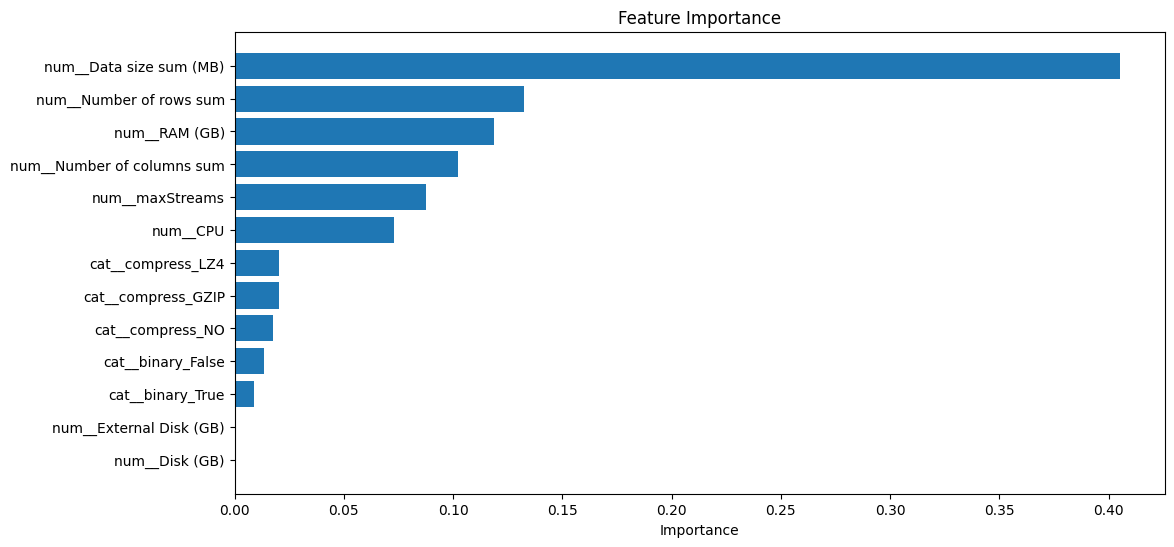

In [84]:
feature_importances_mean = feature_importances_df.mean(axis=1)

# Sort the feature importances
sorted_idx = np.argsort(feature_importances_mean)

# Plot
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importances_mean.iloc[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_importances_df.index[sorted_idx])  # Use the feature names
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()